In [177]:
import json
from sklearn.metrics import roc_curve, precision_recall_curve, auc

import pandas as pd


In [178]:
def get_self(model_name,revision='main',dataset='squad'):
    directory_results =f'/home/niloofar/projects/detect-gpt-copying/results/mistral/{model_name}-{revision}-t5-3b-temp/fp32-0.3-1-{dataset}-312/'
    if not os.path.isfile(directory_results + 'perturbation_25_d_results.json'):
        return -1
    with open(directory_results + 'perturbation_25_d_results.json') as f:
        small_t_dict = json.load(f)
        return(small_t_dict["metrics"]["roc_auc"])




def get_sample_original_lls_perts(model_name,revision='main',dataset='squad'):

    directory =f'/home/niloofar/projects/detect-gpt-copying/results/mistral/{model_name}-{revision}-t5-3b-temp/fp32-0.3-1-{dataset}-312/'

    original_ll = []
    original_ll_pert = []
    original = []

    sampled_ll= []
    sampled_ll_pert = []
    sampled = []

    with open(directory + 'perturbation_25_d_results.json') as f:
        small_t_dict = json.load(f)
        s_original = small_t_dict["predictions"]["real"]
        s_samples = small_t_dict["predictions"]["samples"]
        raw_res_list = small_t_dict["raw_results"]
        roc = small_t_dict['metrics']['roc_auc']
        for res in raw_res_list:
            original_ll.append(res['original_ll'])
            original_ll_pert.append(res['all_perturbed_original_ll'])

            sampled_ll.append(res['sampled_ll'])
            sampled_ll_pert.append(res['all_perturbed_sampled_ll'])

            original.append(res['original'])
            sampled.append(res['sampled'])


    print(len(original), len(sampled),len(s_original),len(s_samples))


    zipped_raw = dict(zip(original, s_original))
    zipped_sample= dict(zip(sampled, s_samples))

 

    return original, sampled,s_original,s_samples, zipped_raw,zipped_sample, roc, sampled_ll, original_ll


def get_roc_metrics(real_preds, sample_preds):
    fpr, tpr, _ = roc_curve([0] * len(real_preds) + [1] * len(sample_preds), real_preds + sample_preds)
    roc_auc = auc(fpr, tpr)
    return fpr.tolist(), tpr.tolist(), float(roc_auc)




In [179]:
# EleutherAI_pythia-2.8b-deduped-main-t5-3b-temp
model_name = 'EleutherAI_gpt-neo-2.7B'
dataset = 'the_pile'

org, sampled, s_original, s_sampled, zipped_raw, zipped_sample, roc,sampled_ll, original_ll = get_sample_original_lls_perts(model_name,dataset=dataset)


300 300 300 300


In [180]:
sorted_samples = dict(sorted(zipped_sample.items(), key=lambda item: item[1]))
sorted_original = dict(sorted(zipped_raw.items(), key=lambda item: item[1]))

In [181]:
print(list(sorted_samples.values())[-10:])
print(list(sorted_original.values())[-10:])
print(list(sorted_original.keys())[-10:])

[0.2671435451507569, 0.2730464744567871, 0.274623041152954, 0.28587398529052743, 0.2952162361145019, 0.29644101142883295, 0.29688239097595215, 0.30466096878051774, 0.4233896446228027, 0.7586448097229006]
[0.1959289312362671, 0.19735346317291258, 0.20037961483001698, 0.20857038497924796, 0.21323387622833234, 0.22009231567382814, 0.23493507385253887, 0.23874626636505125, 0.24143308162689214, 0.32819096565246575]
['Polymerase chain reaction for diagnosing pneumocystis pneumonia in non-HIV immunocompromised patients with pulmonary infiltrates. Pneumocystis jiroveci polymerase chain reaction (PCR) has higher sensitivity than conventional stains but cannot distinguish colonization from infection. We compared P jiroveci PCR and conventional stains in HIV-uninfected immunocompromised patients. Among the 448 patients, 296 (66%) patients had hematologic malignancies; 72 (16.1%), bone marrow transplants; 44 (9.8%), solid tumors; 21 (4.7%), renal transplants; and 15 (3.4%) were taking immunosuppre

In [182]:
fpr, tpr, roc_auc = get_roc_metrics(s_original, s_sampled)
print(roc_auc)
print(roc)

0.8141388888888889
0.8141388888888889


In [183]:
df_dict = {'scores':s_original+s_sampled, 'hue':['original']*len(s_original)+['sampled']*len(s_sampled)}
data_frame = pd.DataFrame.from_dict(df_dict)

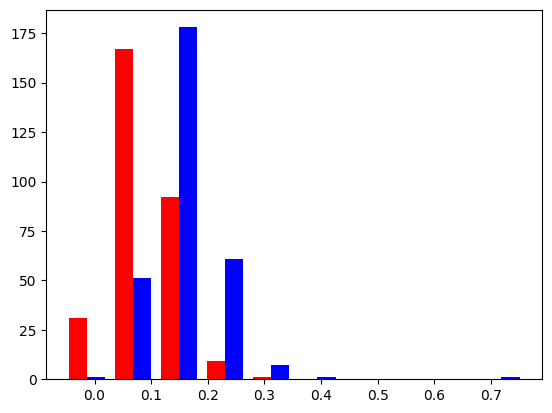

In [184]:
import matplotlib.pyplot as plt


plt.hist([s_original, s_sampled],color=['r','b'])
plt.show()

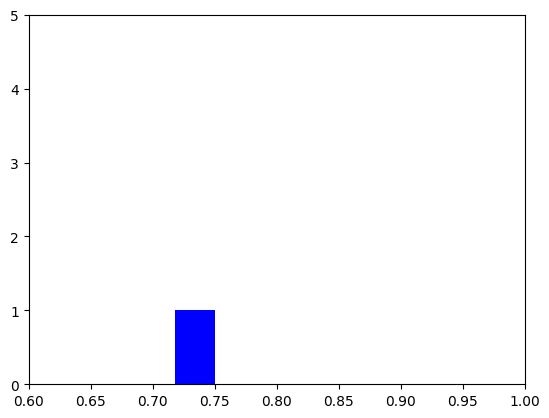

In [185]:
plt.hist([s_original, s_sampled],color=['r','b'])
plt.xlim([0.6,1.0])
plt.ylim([0,5])
plt.show()


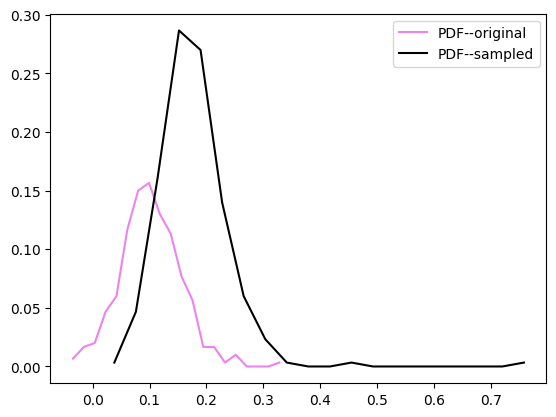

In [186]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
  
# No of Data points
  
# initializing random values
data = s_original #np.random.randn(N)
  
# getting data of the histogram
count, bins_count = np.histogram(data, bins=20)
  
# finding the PDF of the histogram using count values
pdf = count / sum(count)
  
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)
  
# plotting PDF and CDF
plt.plot(bins_count[1:], pdf, color="violet", label="PDF--original")
#plt.plot(bins_count[1:], cdf, label="CDF")
#plt.legend()

data = s_sampled #np.random.randn(N)
  
# getting data of the histogram
count, bins_count = np.histogram(data, bins=20)
  
# finding the PDF of the histogram using count values
pdf = count / sum(count)
  
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)
  
# plotting PDF and CDF
plt.plot(bins_count[1:], pdf, color="black", label="PDF--sampled")
#plt.plot(bins_count[1:], cdf, label="CDF")
plt.legend()
  
# initializing random values


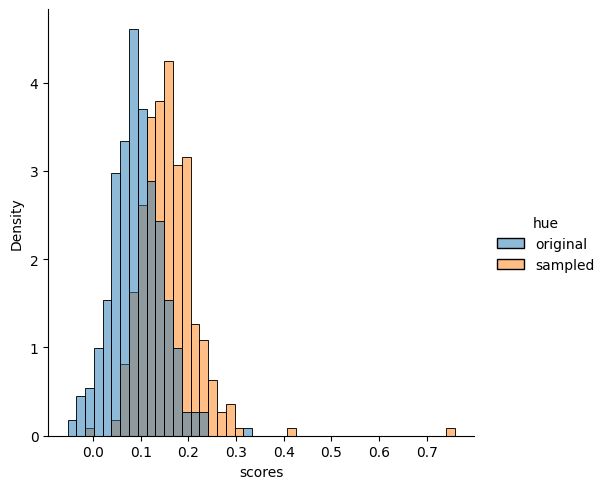

In [187]:
import seaborn as sns
sns.displot(data_frame, x='scores' ,hue="hue", stat="density")

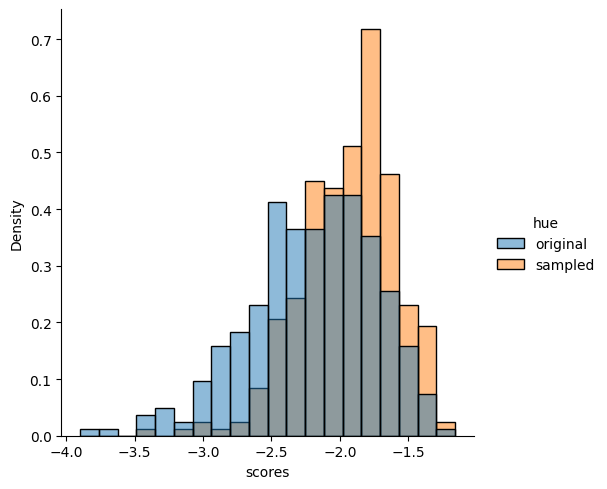

In [188]:
import seaborn as sns

df_dict = {'scores':original_ll+sampled_ll, 'hue':['original']*len(s_original)+['sampled']*len(s_sampled)}
data_frame = pd.DataFrame.from_dict(df_dict)

sns.displot(data_frame, x='scores' ,hue="hue", stat="density")

In [189]:
fpr, tpr, roc_auc = get_roc_metrics(original_ll, sampled_ll)
print(roc_auc)
print(roc)

0.67095
0.8141388888888889


In [190]:
zipped_raw = dict(zip(org, original_ll))
zipped_sample= dict(zip(sampled, sampled_ll))

In [191]:
sorted_samples = dict(sorted(zipped_sample.items(), key=lambda item: item[1]))
sorted_original = dict(sorted(zipped_raw.items(), key=lambda item: item[1]))

In [192]:
print(list(sorted_samples.values())[-10:])
print(list(sorted_original.values())[-10:])
print(list(sorted_original.keys())[-10:])

[-1.3961678743362427, -1.3791245222091675, -1.3735620975494385, -1.3727716207504272, -1.3446650505065918, -1.3417208194732666, -1.3321051597595215, -1.2991656064987183, -1.2836767435073853, -1.2343446016311646]
[-1.4662494659423828, -1.435272216796875, -1.4318658113479614, -1.417521595954895, -1.3808250427246094, -1.370002031326294, -1.3662800788879395, -1.3586047887802124, -1.354809045791626, -1.1567082405090332]
['Interleukin 5 release into asthmatic airways 4 and 24 hours after endobronchial allergen challenge: its relationship with eosinophil recruitment. Interleukin 5 (IL-5), a cytokine with a range of activities on eosinophils, has been implicated in the allergic asthmatic reaction. We have investigated the kinetics of release of this cytokine into asthmatic airways as well as its relationship to eosinophil recruitment following allergen challenge. Twelve asthmatic patients underwent endobronchial allergen challenge and bronchoalveolar lavage (BAL) fluid was obtained either 4 h (

In [87]:
#/home/niloofar/projects/detect-gpt-copying/results/lira/EleutherAI_gpt-j-6B-main-t5-base-temp/fp32-0.3-1-the_pile-312--distilgpt2/rank_threshold_results.json
#/home/niloofar/projects/detect-gpt-copying/results/lira/EleutherAI_gpt-neo-2.7B-main-t5-base-temp/fp32-0.3-1-the_pile-312--distilgpt2/rank_threshold_results.json
def get_sample_original_lls_perts(model_name,revision='main',dataset='squad'):

    directory ='/home/niloofar/projects/detect-gpt-copying/results/lira/EleutherAI_gpt-neo-2.7B-main-t5-base-temp/fp32-0.3-1-the_pile-312--distilgpt2/'

    original_ll = []
    original_ll_pert = []
    original = []

    sampled_ll= []
    sampled_ll_pert = []
    sampled = []

    with open(directory + 'rank_threshold_results.json') as f:
        small_t_dict = json.load(f)
        s_original = small_t_dict["predictions"]["real"]
        s_samples = small_t_dict["predictions"]["samples"]
        raw_res_list = small_t_dict["raw_results"]
        roc = small_t_dict['metrics']['roc_auc']
        for res in raw_res_list:
            original_ll.append(res['original_crit'])

            sampled_ll.append(res['sampled_crit'])

            original.append(res['original'])
            sampled.append(res['sampled'])


    print(len(original), len(sampled),len(s_original),len(s_samples))


    zipped_raw = dict(zip(original, s_original))
    zipped_sample= dict(zip(sampled, s_samples))

 

    return original, sampled,s_original,s_samples, zipped_raw,zipped_sample, roc, sampled_ll, original_ll

In [88]:
# EleutherAI_pythia-2.8b-deduped-main-t5-3b-temp
model_name = 'facebook_opt-6.7b'
dataset = 'the_pile'

org, sampled, s_original, s_sampled, zipped_raw, zipped_sample, roc,sampled_ll, original_ll = get_sample_original_lls_perts(model_name,dataset=dataset)


300 300 300 300


In [89]:
df_dict = {'scores':s_original+s_sampled, 'hue':['original']*len(s_original)+['sampled']*len(s_sampled)}
data_frame = pd.DataFrame.from_dict(df_dict)

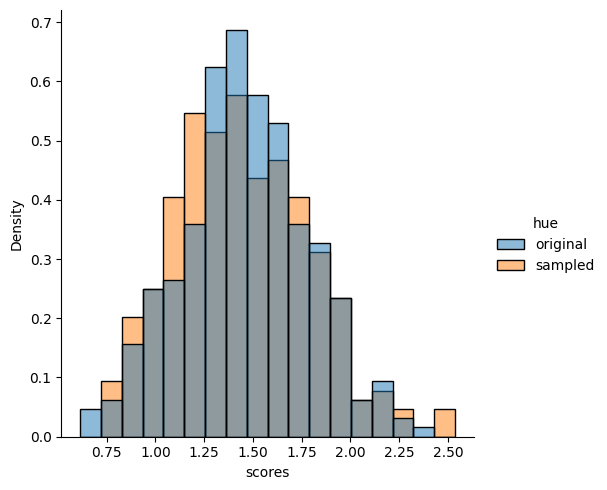

In [90]:
import seaborn as sns
sns.displot(data_frame, x='scores' ,hue="hue", stat="density")

In [91]:
print(roc)

0.4771277777777777


In [92]:
#/home/niloofar/projects/detect-gpt-copying/results/lira/EleutherAI_gpt-j-6B-main-t5-base-temp/fp32-0.3-1-the_pile-312--distilgpt2/rank_threshold_results.json
#/home/niloofar/projects/detect-gpt-copying/results/lira/EleutherAI_gpt-neo-2.7B-main-t5-base-temp/fp32-0.3-1-the_pile-312--distilgpt2/rank_threshold_results.json
def get_sample_original_lls_perts(model_name,revision='main',dataset='squad'):

    directory ='/home/niloofar/projects/detect-gpt-copying/results/lira/EleutherAI_gpt-neo-2.7B-main-t5-base-temp/fp32-0.3-1-the_pile-312--gpt2-xl/'

    original_ll = []
    original_ll_pert = []
    original = []

    sampled_ll= []
    sampled_ll_pert = []
    sampled = []

    with open(directory + 'rank_threshold_results.json') as f:
        small_t_dict = json.load(f)
        s_original = small_t_dict["predictions"]["real"]
        s_samples = small_t_dict["predictions"]["samples"]
        raw_res_list = small_t_dict["raw_results"]
        roc = small_t_dict['metrics']['roc_auc']
        for res in raw_res_list:
            original_ll.append(res['original_crit'])

            sampled_ll.append(res['sampled_crit'])

            original.append(res['original'])
            sampled.append(res['sampled'])


    print(len(original), len(sampled),len(s_original),len(s_samples))


    zipped_raw = dict(zip(original, s_original))
    zipped_sample= dict(zip(sampled, s_samples))

 

    return original, sampled,s_original,s_samples, zipped_raw,zipped_sample, roc, sampled_ll, original_ll

In [93]:
# EleutherAI_pythia-2.8b-deduped-main-t5-3b-temp
model_name = 'facebook_opt-6.7b'
dataset = 'the_pile'

org, sampled, s_original, s_sampled, zipped_raw, zipped_sample, roc,sampled_ll, original_ll = get_sample_original_lls_perts(model_name,dataset=dataset)


300 300 300 300


In [94]:
df_dict = {'scores':s_original+s_sampled, 'hue':['original']*len(s_original)+['sampled']*len(s_sampled)}
data_frame = pd.DataFrame.from_dict(df_dict)

0.5989722222222222


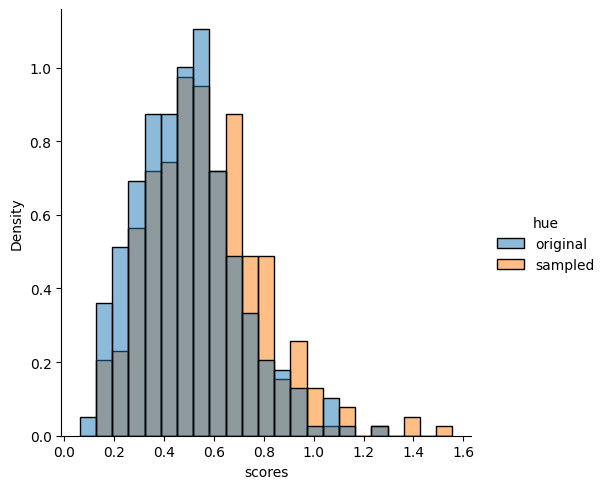

In [96]:
import seaborn as sns
sns.displot(data_frame, x='scores' ,hue="hue", stat="density")
print(roc)

In [150]:
#/home/niloofar/projects/detect-gpt-copying/results/lira/EleutherAI_gpt-j-6B-main-t5-base-temp/fp32-0.3-1-the_pile-312--distilgpt2/rank_threshold_results.json
#/home/niloofar/projects/detect-gpt-copying/results/lira/EleutherAI_gpt-neo-2.7B-main-t5-base-temp/fp32-0.3-1-the_pile-312--distilgpt2/rank_threshold_results.json
def get_sample_original_lls_perts(model_name,revision='main',dataset='squad'):

    directory ='/home/niloofar/projects/detect-gpt-copying/results/lira/EleutherAI_gpt-neo-2.7B-main-t5-base-temp/fp32-0.3-1-the_pile-312--gpt2-xl/'

    original_ll = []
    original_ll_pert = []
    original = []

    sampled_ll= []
    sampled_ll_pert = []
    sampled = []

    with open(directory + 'rank_threshold_results.json') as f:
        small_t_dict = json.load(f)
        s_original = small_t_dict["predictions"]["real"]
        s_samples = small_t_dict["predictions"]["samples"]
        raw_res_list = small_t_dict["raw_results"]
        roc = small_t_dict['metrics']['roc_auc']
        for res in raw_res_list:
            original_ll.append(res['original_crit'])

            sampled_ll.append(res['sampled_crit'])

            original.append(res['original'])
            sampled.append(res['sampled'])


    print(len(original), len(sampled),len(s_original),len(s_samples))


    zipped_raw = dict(zip(original, s_original))
    zipped_sample= dict(zip(sampled, s_samples))

 

    return original, sampled,s_original,s_samples, zipped_raw,zipped_sample, roc, sampled_ll, original_ll

In [151]:
# EleutherAI_pythia-2.8b-deduped-main-t5-3b-temp
model_name = 'facebook_opt-6.7b'
dataset = 'the_pile'

org, sampled, s_original, s_sampled, zipped_raw, zipped_sample, roc,sampled_ll, original_ll = get_sample_original_lls_perts(model_name,dataset=dataset)


300 300 300 300


In [152]:
df_dict = {'scores':s_original+s_sampled, 'hue':['original']*len(s_original)+['sampled']*len(s_sampled)}
data_frame = pd.DataFrame.from_dict(df_dict)

0.5989722222222222


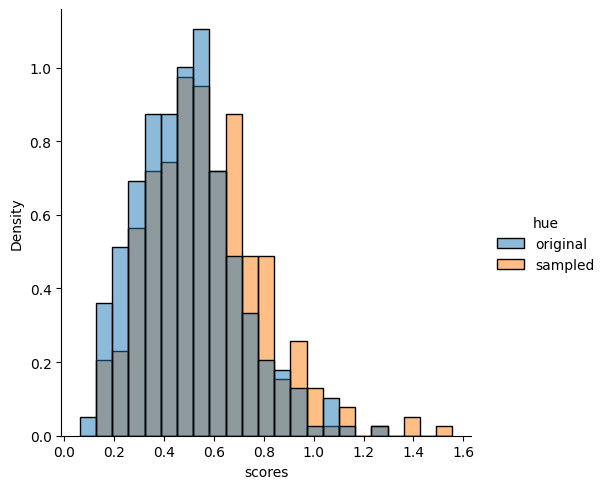

In [153]:
import seaborn as sns
sns.displot(data_frame, x='scores' ,hue="hue", stat="density")
print(roc)

In [154]:
sorted_samples = dict(sorted(zipped_sample.items(), key=lambda item: item[1]))
sorted_original = dict(sorted(zipped_raw.items(), key=lambda item: item[1]))

In [155]:
print(list(sorted_samples.values())[-10:])
print(list(sorted_original.values())[-10:])
print(list(sorted_original.keys())[-10:])

[1.0034410953521729, 1.012874722480774, 1.0717946290969849, 1.1187913417816162, 1.1493496894836426, 1.1531859636306763, 1.268441915512085, 1.3820077180862427, 1.4070966243743896, 1.555801510810852]
[0.9290764331817627, 0.9429956674575806, 0.9539947509765625, 1.017547845840454, 1.0446326732635498, 1.0458121299743652, 1.0512709617614746, 1.0558722019195557, 1.1059471368789673, 1.243868112564087]
["[Leishmaniasis in Greece. Results of an entomological survey during June 1977 (author's transl)]. In relation with the recent outbreak of leishmaniasis in Greece, the authors undertook entomological investigations for delimiting the foci of transmission. A first survey, during june 1977, in continental Greece, gave 6 633 sandflies with 21% of P. major and 20% of P. perfiliewi. Captures are analysed for each species with systematic and epidemiological comments.", "[Chemical constituents from Glechoma longituba]. Fourteen compounds were obtained from Glechoma longituba by the chromatographic meth

In [156]:
#/home/niloofar/projects/detect-gpt-copying/results/lira/EleutherAI_gpt-j-6B-main-t5-base-temp/fp32-0.3-1-the_pile-312--distilgpt2/rank_threshold_results.json
#/home/niloofar/projects/detect-gpt-copying/results/lira/EleutherAI_gpt-neo-2.7B-main-t5-base-temp/fp32-0.3-1-the_pile-312--distilgpt2/rank_threshold_results.json
def get_sample_original_lls_perts(model_name,revision='main',dataset='squad'):

    directory ='/home/niloofar/projects/detect-gpt-copying/results/lira/EleutherAI_gpt-neo-2.7B-main-t5-base-temp/fp32-0.3-1-the_pile-312--gpt2-xl/'

    original_ll = []
    original_ll_pert = []
    original = []

    sampled_ll= []
    sampled_ll_pert = []
    sampled = []

    with open(directory + 'perturbation_25_d_results.json') as f:
        small_t_dict = json.load(f)
        s_original = small_t_dict["predictions"]["real"]
        s_samples = small_t_dict["predictions"]["samples"]
        raw_res_list = small_t_dict["raw_results"]
        roc = small_t_dict['metrics']['roc_auc']
        for res in raw_res_list:
            original_ll.append(res['original_ll'])
            original_ll_pert.append(res['all_perturbed_original_ll'])

            sampled_ll.append(res['sampled_ll'])
            sampled_ll_pert.append(res['all_perturbed_sampled_ll'])

            original.append(res['original'])
            sampled.append(res['sampled'])

    print(len(original), len(sampled),len(s_original),len(s_samples))


    zipped_raw = dict(zip(original, s_original))
    zipped_sample= dict(zip(sampled, s_samples))

 

    return original, sampled,s_original,s_samples, zipped_raw,zipped_sample, roc, sampled_ll, original_ll

In [157]:
# EleutherAI_pythia-2.8b-deduped-main-t5-3b-temp
model_name = 'facebook_opt-6.7b'
dataset = 'the_pile'

org, sampled, s_original, s_sampled, zipped_raw, zipped_sample, roc,sampled_ll, original_ll = get_sample_original_lls_perts(model_name,dataset=dataset)


300 300 300 300


In [158]:
df_dict = {'scores':s_original+s_sampled, 'hue':['original']*len(s_original)+['sampled']*len(s_sampled)}
data_frame = pd.DataFrame.from_dict(df_dict)

0.6221833333333333


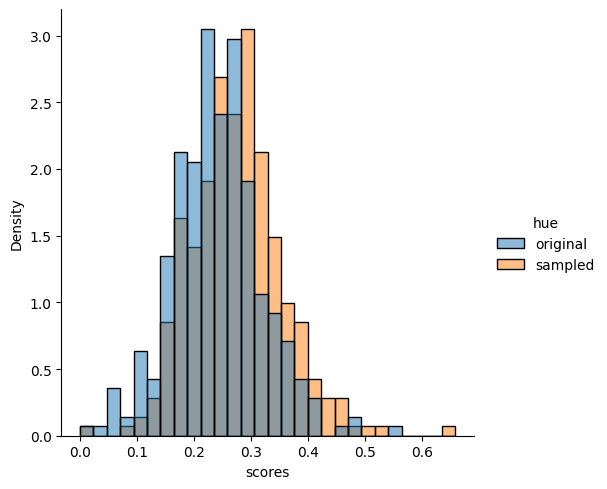

In [159]:
import seaborn as sns
sns.displot(data_frame, x='scores' ,hue="hue", stat="density")
print(roc)

In [160]:
sorted_samples = dict(sorted(zipped_sample.items(), key=lambda item: item[1]))
sorted_original = dict(sorted(zipped_raw.items(), key=lambda item: item[1]))

In [161]:
print(list(sorted_samples.values())[-10:])
print(list(sorted_original.values())[-10:])
print(list(sorted_original.keys())[-10:])

[0.43348910808563224, 0.4347227382659913, 0.44893776893615733, 0.45127689838409424, 0.4609330892562866, 0.47017334938049316, 0.49389887809753397, 0.5040799808502197, 0.5210249853134155, 0.6586062955856322]
[0.38085257530212413, 0.3900514125823973, 0.4045293235778811, 0.410922646522522, 0.41798473358154276, 0.4220293712615968, 0.45822679042816183, 0.47190542221069354, 0.4732307243347167, 0.5470843839645387]
['The human cytomegalovirus genome revisited: comparison with the chimpanzee cytomegalovirus genome. The gene complement of wild-type human cytomegalovirus (HCMV) is incompletely understood, on account of the size and complexity of the viral genome and because laboratory strains have undergone deletions and rearrangements during adaptation to growth in culture. We have determined the sequence (241 087 bp) of chimpanzee cytomegalovirus (CCMV) and have compared it with published HCMV sequences from the laboratory strains AD169 and Toledo, with the aim of clarifying the gene content of 

In [162]:
df_dict = {'scores':original_ll+sampled_ll, 'hue':['original']*len(s_original)+['sampled']*len(s_sampled)}
data_frame = pd.DataFrame.from_dict(df_dict)

0.6221833333333333


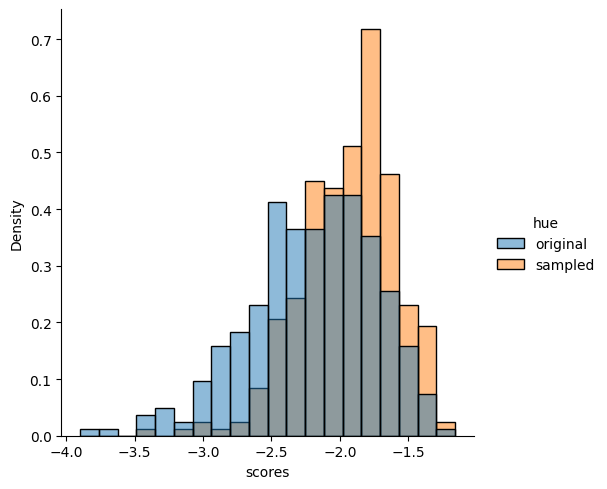

In [163]:
import seaborn as sns
sns.displot(data_frame, x='scores' ,hue="hue", stat="density")
print(roc)

In [148]:
zipped_raw = dict(zip(org, original_ll))
zipped_sample= dict(zip(sampled, sampled_ll))

sorted_samples = dict(sorted(zipped_sample.items(), key=lambda item: item[1]))
sorted_original = dict(sorted(zipped_raw.items(), key=lambda item: item[1]))

In [149]:
print(list(sorted_samples.values())[-10:])
print(list(sorted_original.values())[-10:])
print(list(sorted_original.keys())[-10:])

[-1.3961678743362427, -1.3791245222091675, -1.3735620975494385, -1.3727716207504272, -1.3446650505065918, -1.3417208194732666, -1.3321051597595215, -1.2991656064987183, -1.2836767435073853, -1.2343446016311646]
[-1.4662494659423828, -1.435272216796875, -1.4318658113479614, -1.417521595954895, -1.3808250427246094, -1.370002031326294, -1.3662800788879395, -1.3586047887802124, -1.354809045791626, -1.1567082405090332]
['Interleukin 5 release into asthmatic airways 4 and 24 hours after endobronchial allergen challenge: its relationship with eosinophil recruitment. Interleukin 5 (IL-5), a cytokine with a range of activities on eosinophils, has been implicated in the allergic asthmatic reaction. We have investigated the kinetics of release of this cytokine into asthmatic airways as well as its relationship to eosinophil recruitment following allergen challenge. Twelve asthmatic patients underwent endobronchial allergen challenge and bronchoalveolar lavage (BAL) fluid was obtained either 4 h (